In [ ]:
import pandas as pd
from google.colab import files 
uploaded = files.upload()
df = pd.read_csv('Tractor-Sales.csv')
df.describe(include='all')

Saving Tractor-Sales.csv to Tractor-Sales (2).csv


,Month-Year,Number of Tractor Sold
count,144,144.000000
unique,144,NaN
top,3-Jan,NaN
freq,1,NaN
mean,NaN,389.694444
std,NaN,171.500016
min,NaN,138.000000
25%,NaN,248.500000
50%,NaN,369.000000
75%,NaN,509.250000


In [ ]:
df

,Month-Year,Number of Tractor Sold
0,3-Jan,141
1,3-Feb,157
2,3-Mar,185
3,3-Apr,199
4,3-May,203
...,...,...
139,14-Aug,848
140,14-Sep,640
141,14-Oct,581
142,14-Nov,519


In [ ]:
# transfer data into a time series 
dates = pd.date_range(start='2003-01-01', freq='MS', periods=len(df))
df['Date']=dates
df.set_index("Date",inplace=True)
sales_ts=df['Number of Tractor Sold']
sales_ts

Date
2003-01-01    141
2003-02-01    157
2003-03-01    185
2003-04-01    199
2003-05-01    203
             ... 
2014-08-01    848
2014-09-01    640
2014-10-01    581
2014-11-01    519
2014-12-01    605
Name: Number of Tractor Sold, Length: 144, dtype: int64

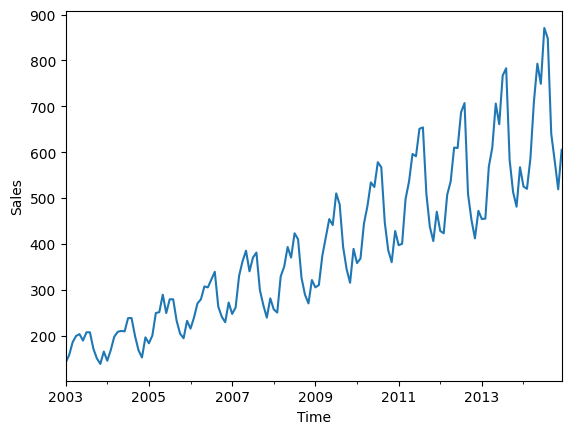

In [ ]:
# check the stationary of the time series data
import matplotlib.pylab as plt
ax=sales_ts.plot()
ax.set_xlabel('Time')
ax.set_ylabel('Sales')
plt.show()

In [ ]:
# unit root test
from statsmodels.tsa.stattools import adfuller
print('Results of Dickey-Fuller Test:')
dftest = adfuller(sales_ts,autolag='AIC')
dfoutput = pd.Series(dftest[0:4],
index=['Test Statistic',
'p-value',
'#lags used',
'Number of obervations used'])

for key, value in dftest[4].items():
  dfoutput['Critical Value (%s)'%key]=value


## statistic test to see if it is stationary we see that this data is NOT stationary
### how can we then make it more staitonary
### we can log transform the data if it is highly skewed
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  1.108825
p-value                         0.995291
#lags used                     14.000000
Number of obervations used    129.000000
Critical Value (1%)            -3.482088
Critical Value (5%)            -2.884219
Critical Value (10%)           -2.578864
dtype: float64


In [ ]:
import numpy as np
sales_ts_log = np.log10(sales_ts)

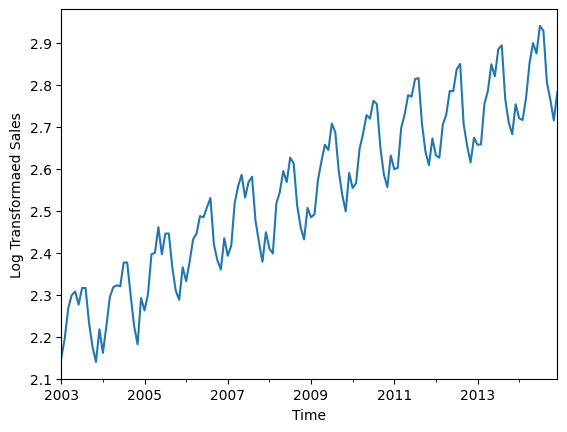

In [ ]:
ax=sales_ts_log.plot()
ax.set_xlabel('Time')
ax.set_ylabel('Log Transformaed Sales')
plt.show()

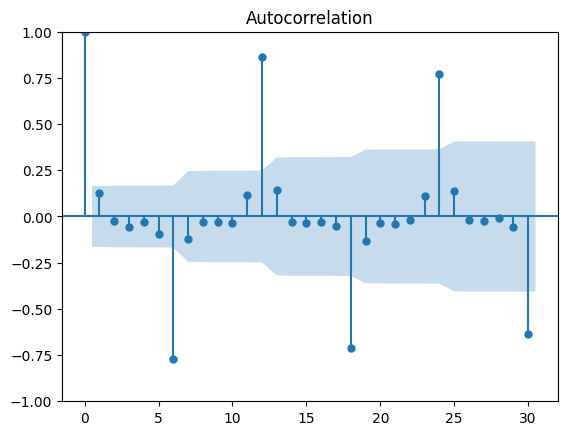

In [ ]:
# difference
import statsmodels.tsa.api as smt
sales_ts_log_diff = sales_ts_log.diff(periods=1)
sales_ts_log_diff.dropna(inplace=True)


# from this plot we can see the 5% alpha range which mean there is a significant value during said period
# what can we infer? ie when month = 6 we have a negative correlation
# ACF test
smt.graphics.plot_acf(sales_ts_log_diff,
lags=30,
alpha=0.05)
plt.show()

In [ ]:
nValid =36
nTrain = len(sales_ts_log)-nValid
##note we used the log transformed instead of the difference arima can deal with difference 
train_ts = sales_ts_log[:nTrain]
valid_ts = sales_ts_log[nTrain:]

In [ ]:
!pip install pmdarima
from pmdarima import auto_arima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
model = auto_arima(sales_ts_log, trace=True, information_criterion='aic', seasonal=True, m=12, start_p = 1, start_1 = 1, d =1)

Performing stepwise search to minimize aic
 ARIMA(1,1,2)(1,1,1)[12]             : AIC=-697.293, Time=2.28 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-653.884, Time=0.10 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-694.787, Time=0.81 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-702.786, Time=2.16 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-669.792, Time=0.11 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=-701.290, Time=1.46 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=-701.328, Time=4.45 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=-697.118, Time=1.66 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=-699.292, Time=4.47 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=-686.399, Time=0.94 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-701.098, Time=3.47 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=-700.921, Time=3.91 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=-701.028, Time=1.37 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=-698.787, Time=2.17 sec
 ARIMA(0,1,1)(0,1,1

In [ ]:
import statsmodels.api as sm

best_model = sm.tsa.statespace.SARIMAX(train_ts,
order=(0,1,1),
seasonal_order=(0,1,1,12))
best_results = best_model.fit()

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [ ]:
print(best_results.summary().tables[0])
print(best_results.summary().tables[1])


print(best_results.summary())
##ma.l1 base 
##ma.s.l12 seasonal 
#sigma2 is the variance it shows the fit and you can determine if you need to trasnform your data set based on this variable.

                                     SARIMAX Results                                      
Dep. Variable:             Number of Tractor Sold   No. Observations:                  108
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 254.717
Date:                            Tue, 18 Apr 2023   AIC                           -503.434
Time:                                    23:26:15   BIC                           -495.772
Sample:                                01-01-2003   HQIC                          -500.338
                                     - 12-01-2011                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3918      0.097     -4.052      0.000      -0.581      -0.202
ma.S.L12      -0.5814      0.112   

In [ ]:
pred = best_results.get_forecast(steps=36,alpha=0.05)

In [ ]:
!pip install dmba
from dmba import regressionSummary
#10 to the power is to reverse the log transformation done on an earlier step
regressionSummary(np.power(10,valid_ts),
np.power(10,pred.predicted_mean))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 67.6 MB/s eta 0:00:00
no display found. Using non-interactive Agg backend

Regression statistics

                      Mean Error (ME) : -46.9705
       Root Mean Squared Error (RMSE) : 50.9143
            Mean Absolute Error (MAE) : 46.9705
          Mean Percentage Error (MPE) : -8.1350
Mean Absolute Percentage Error (MAPE) : 8.1350
